# Peak and tilt determination by fitting Lorentzians to projections

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import xrayutilities as xu
import h5py
import lib.calc as calc
import lib.plot_mpl as plot
from imp import reload

Way to do this: select a roi using the `viewer.py` script. Remember that the stitched and gridded scans are stored in `E16014_stitch.h5`. 

In [2]:
slist = np.load('../stitched_data/scan_list.npy')
slist

array([[ 42,  43,  44,  45],
       [ 75,  76,  77,  78],
       [102, 103, 104, 105],
       [129, 130, 131, 132],
       [156, 157, 158, 159],
       [188, 189, 190, 191],
       [217, 218, 219, 220],
       [247, 248, 249, 250],
       [275, 276, 277, 278],
       [304, 305, 306, 307],
       [327, 328, 329, 330],
       [350, 351, 352, 353],
       [373, 374, 375, 376],
       [396, 397, 398, 399],
       [419, 420, 421, 422],
       [442, 443, 444, 445],
       [465, 466, 467, 468],
       [488, 489, 490, 491]])

In [416]:
fname = '129_132'
gint = calc.read_h5_stitched_e16014(fname) # gridded stitched intensity
Qx,Qy,Qz = calc.read_q_h5_stitched_e16014(fname) # Q's
# sdata = np.load('../stitched_data/42_45.npy')
# Qx, Qy, Qz, gint = calc.qconvert_e16014_grid('../data/hc3211.h5',slist[0],sdata)
qx, qy, qz = calc.make_qmesh(Qx, Qy, Qz, gint) # mesh the q's

(35, 30, 20)


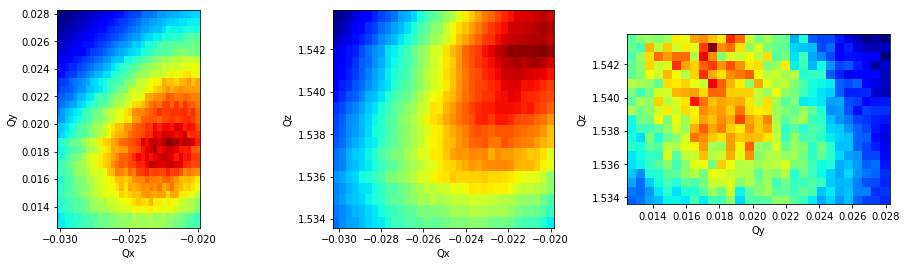

In [425]:
iroi = np.s_[335:370,260:290,110:130] # up to_191
# iroi = np.s_[280:400,240:320,50:150]
# iroi = np.s_[230:290,250:300,100:170]
roi, qxr, qyr, qzr = [array[iroi] for array in (gint, qx, qy, qz)]
# roi = np.log(roi+1)
roi += 1
print(roi.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],roi.sum(axis=2),cmap='jet')
ax1.set_ylabel('Qy');ax1.set_xlabel('Qx')
ax1.set_aspect('equal')

ax2.pcolormesh(qxr[:,0,:],qzr[:,0,:],roi.sum(axis=1),cmap='jet')
ax2.set_ylabel('Qz');ax2.set_xlabel('Qx')
ax2.set_aspect('equal')

ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],roi.sum(axis=0),cmap='jet')
ax3.set_ylabel('Qz');ax3.set_xlabel('Qy')
ax3.set_aspect('equal')


plt.savefig('peaks_'+fname+'_roi')
plt.show()


Seems like a good ROI. Try to make the projections and fit them:

In [426]:
import peakutils as pk

In [427]:
qxx = Qx[iroi[0]]
qyy = Qy[iroi[1]]
qzz = Qz[iroi[2]]

p2 = roi.sum(axis=0).sum(axis=0)
p1 = roi.sum(axis=0).sum(axis=1)
p0 = roi.sum(axis=2).sum(axis=1)

In [428]:
roi.shape

(35, 30, 20)

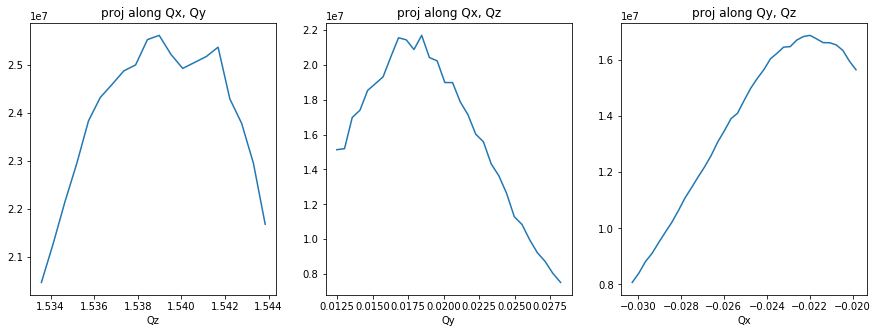

In [429]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

ax1.plot(qzz,p2) # proj. axis 2
ax1.set_title('proj along Qx, Qy')
ax1.set_xlabel('Qz')

ax2.plot(qyy,p1) # proj. axis 1
ax2.set_title('proj along Qx, Qz')
ax2.set_xlabel('Qy')

ax3.plot(qxx,p0) # proj. axis 0
ax3.set_title('proj along Qy, Qz')
ax3.set_xlabel('Qx')

plt.show()

/users/zatterin/Envs/py3/lib/python3.5/site-packages/peakutils/peak.py:216: UserWarning: At least 3 points required for Gaussian fitting
  warnings.warn(str(e))


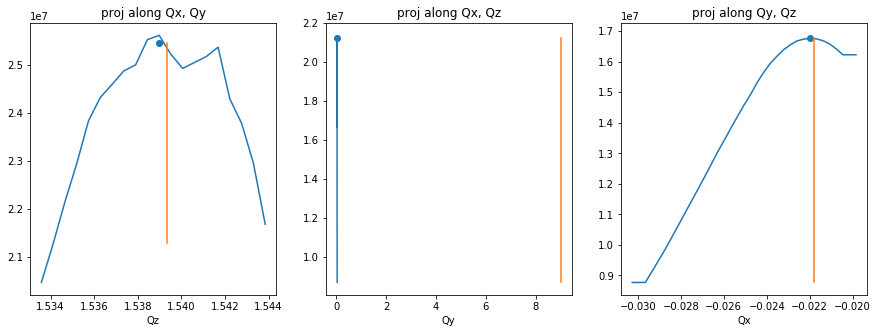

In [430]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

ax1.set_title('proj along Qx, Qy')
p2_smooth = savgol_filter(p2,3, 0)
p2_peak = pk.indexes(p2_smooth, thres=0.99)
ax1.plot(qzz,p2)
ax1.scatter(qzz[p2_peak], p2_smooth[p2_peak]);
qz_gauss = pk.interpolate(qzz,p2_smooth,ind=p2_peak)
ax1.plot([qz_gauss,qz_gauss],[p2_smooth.min(),p2_smooth.max()])
ax1.set_xlabel('Qz')

ax2.set_title('proj along Qx, Qz')
p1_smooth = savgol_filter(p1, 5, 0)
p1_peak = pk.indexes(p1_smooth, thres=0.99)
ax2.plot(qyy,p1_smooth)
ax2.scatter(qyy[p1_peak], p1_smooth[p1_peak]);
qy_gauss = pk.interpolate(qyy,p1_smooth,ind=p1_peak)
ax2.plot([qy_gauss,qy_gauss],[p1_smooth.min(),p1_smooth.max()])
ax2.set_xlabel('Qy')

ax3.set_title('proj along Qy, Qz')
p0_smooth = savgol_filter(p0, 5, 0)
p0_peak = pk.indexes(p0_smooth, thres=0.99)
ax3.plot(qxx,p0_smooth)
ax3.scatter(qxx[p0_peak], p0_smooth[p0_peak]);
qx_gauss = pk.interpolate(qxx,p0_smooth,ind=p0_peak)
ax3.plot([qx_gauss,qx_gauss],[p0_smooth.min(),p0_smooth.max()])
ax3.set_xlabel('Qx')

plt.show()

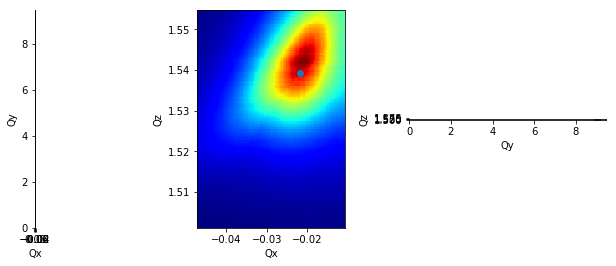

In [431]:
iroi = np.s_[280:400,240:320,50:150]
roi, qxr, qyr, qzr = [array[iroi] for array in (gint, qx, qy, qz)]

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],roi.sum(axis=2),cmap='jet')
ax1.set_ylabel('Qy');ax1.set_xlabel('Qx')
ax1.scatter(qx_gauss,qy_gauss)
ax1.set_aspect('equal')

ax2.pcolormesh(qxr[:,0,:],qzr[:,0,:],roi.sum(axis=1),cmap='jet')
ax2.set_ylabel('Qz');ax2.set_xlabel('Qx')
ax2.scatter(qx_gauss, qz_gauss)
ax2.set_aspect('equal')

ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],roi.sum(axis=0),cmap='jet')
ax3.set_ylabel('Qz');ax3.set_xlabel('Qy')
ax3.scatter(qy_gauss, qz_gauss)
ax3.set_aspect('equal')

plt.savefig('peaks_'+fname)
plt.show()

In [415]:
qxp, qyp, qzp = qx_gauss,qy_gauss,qz_gauss

q = np.sqrt(qxp**2+qyp**2+qzp**2)

_001 = (2*np.pi)/q
ang = np.rad2deg(np.arcsin((np.sqrt(qxp**2+qyp**2)/q)))

print(_001) # length of the q vector
# print((2*np.pi)/qzp) #
print(ang) # tilt

[ 4.0903723]
[ 1.07681622]


### Lorentzians

Try to fit a Lorentzian to these peaks

In [117]:
def lorentzian(x,p):# fwhm, peak centre, intensity
    y = p[2]*(p[0]**2/((x-p[1])**2 + p[0]**2))
    return y

def residual(p,y,x):
    err = y - lorentzian(x,p)
    return err

In [118]:
from scipy.optimize import leastsq
from scipy.signal import savgol_filter

Estimate peak value from smoothed function

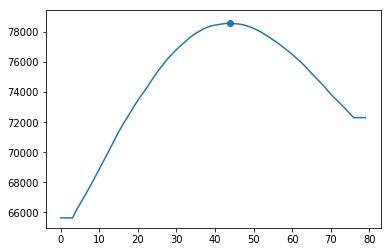

In [124]:
# p2
p2 = p2[:80]
p2_smooth = savgol_filter(p2, 7, 0)
p2_peak = pk.indexes(p2_smooth, thres=0.99)
plt.plot(p2_smooth)
plt.scatter(p2_peak, p2_smooth[p2_peak]);

Init Lorentzian values:

In [125]:
p2_init = [50,p2_peak, p2_smooth[p2_peak]] # fwhm, peak centre, intensity

In [126]:
p2_optimised = leastsq(residual, p2_init,args=(p2,range(len(p2))))[0]

In [127]:
p2_fit = lorentzian(range(len(p2)),p2_optimised)

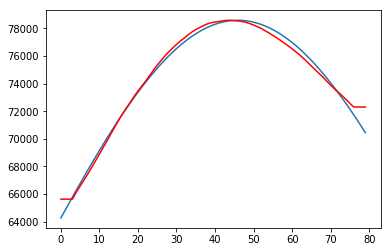

In [128]:
plt.plot(p2_fit)
plt.plot(p2_smooth,c='r')
plt.show()

This is what their eye estimation looks like. Not quite there -- the shape of the peak not being parallel to the q axes is making a difference.

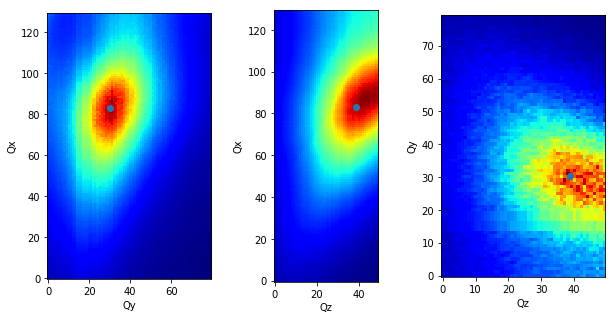

In [233]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))
ax1.imshow(roi.sum(axis=2),origin='lower',cmap='jet')
ax1.set_ylabel('Qx');ax1.set_xlabel('Qy')
# ax1.scatter(COM[1],COM[0],c='b')
ax1.scatter(30.3,83)
ax1.set_aspect('equal')

ax2.imshow(roi.sum(axis=1),origin='lower',cmap='jet')
ax2.set_ylabel('Qx');ax2.set_xlabel('Qz')
# ax2.scatter(COM[2],COM[0])
ax2.scatter(38.67,83)
ax2.set_aspect('equal')

ax3.imshow(roi.sum(axis=0),origin='lower',cmap='jet')
ax3.set_ylabel('Qy');ax3.set_xlabel('Qz')
# ax1.scatter(COM[1],COM[0],c='b')
ax3.set_aspect('equal')
ax3.scatter(38.67,30.3)
plt.show()